1. Loading dependencies.

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
from windrose import WindroseAxes





2. Summary Statistics & Missing-Value Report

In [83]:
df = pd.read_csv('..\\data\\togo-dapaong_qc.csv', parse_dates=['Timestamp'])  # add parse_dates parameter
# 1. Summary statistics for all numeric columns
numeric_summary = df.describe()

# 2. Count of missing values in each column
missing_counts = df.isna().sum()

# 3. Identifying columns with >5% missing values
threshold = 0.05 * len(df)
high_na_columns = missing_counts[missing_counts > threshold].index.tolist()

# Printing the results
print("Summary Statistics (Numeric Columns):\n", numeric_summary)
print("\nMissing Value Counts:\n", missing_counts)
print("\nColumns with >5% Missing Values:\n", high_na_columns)


Summary Statistics (Numeric Columns):
                            Timestamp            GHI            DNI  \
count                         525600  525600.000000  525600.000000   
mean   2022-04-25 12:00:30.000000768     230.555040     151.258469   
min              2021-10-25 00:01:00     -12.700000       0.000000   
25%              2022-01-24 06:00:45      -2.200000       0.000000   
50%              2022-04-25 12:00:30       2.100000       0.000000   
75%              2022-07-25 18:00:15     442.400000     246.400000   
max              2022-10-25 00:00:00    1424.000000    1004.500000   
std                              NaN     322.532347     250.956962   

                 DHI           ModA           ModB           Tamb  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      116.444352     226.144375     219.568588      27.751788   
min         0.000000       0.000000       0.000000      14.900000   
25%         0.000000       0.000000       0.000000    

3. missing values

In [84]:
# Checking for missing values in key columns
key_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
missing_counts = df[key_columns].isna().sum()
print("Missing Values:\n", missing_counts)




Missing Values:
 GHI       0
DNI       0
DHI       0
ModA      0
ModB      0
WS        0
WSgust    0
dtype: int64


4. Incorrect entries Solar Irradiance (GHI, DNI, DHI)

In [85]:
# Negative values (physically impossible)
invalid_ghi = df[df['GHI'] < 0]
invalid_dni = df[df['DNI'] < 0]
invalid_dhi = df[df['DHI'] < 0]

# Unrealistically high values (adjust thresholds)
high_ghi = df[df['GHI'] > 1200]  # Max ~1200 W/m²
high_dni = df[df['DNI'] > 1300]   # Max ~1300 W/m²
high_dhi = df[df['DHI'] > 400]    # Max ~400 W/m²

print("Invalid GHI values:\n", invalid_ghi)
print("Invalid DNI values:\n", invalid_dni)
print("Invalid DHI values:\n", invalid_dhi)
print("High GHI values:\n", high_ghi)
print("High DNI values:\n", high_dni)
print("High DHI values:\n", high_dhi)

Invalid GHI values:
                  Timestamp  GHI  DNI  DHI  ModA  ModB  Tamb    RH   WS  \
0      2021-10-25 00:01:00 -1.3  0.0  0.0   0.0   0.0  24.8  94.5  0.9   
1      2021-10-25 00:02:00 -1.3  0.0  0.0   0.0   0.0  24.8  94.4  1.1   
2      2021-10-25 00:03:00 -1.3  0.0  0.0   0.0   0.0  24.8  94.4  1.2   
3      2021-10-25 00:04:00 -1.2  0.0  0.0   0.0   0.0  24.8  94.3  1.2   
4      2021-10-25 00:05:00 -1.2  0.0  0.0   0.0   0.0  24.8  94.0  1.3   
...                    ...  ...  ...  ...   ...   ...   ...   ...  ...   
525595 2022-10-24 23:56:00 -0.8  0.0  0.0   0.0   0.0  25.2  53.8  0.0   
525596 2022-10-24 23:57:00 -0.9  0.0  0.0   0.0   0.0  25.3  53.5  0.0   
525597 2022-10-24 23:58:00 -1.0  0.0  0.0   0.0   0.0  25.3  53.4  0.0   
525598 2022-10-24 23:59:00 -1.1  0.0  0.0   0.0   0.0  25.4  53.5  0.0   
525599 2022-10-25 00:00:00 -1.2  0.0  0.0   0.0   0.0  25.4  52.3  0.0   

        WSgust  WSstdev     WD  WDstdev   BP  Cleaning  Precipitation  TModA  \
0         

In [86]:
# Negative or stuck values
invalid_moda = df[(df['ModA'] < 0) | (df['ModA'] > 1000)]  # Adjust max threshold
stuck_moda = df['ModA'].nunique() == 1  # No variation → sensor failure?

# Compare ModA vs. ModB for consistency
discrepancy = df[abs(df['ModA'] - df['ModB']) > 100]  # Large differences

6. Incorrect entries Wind Speed (WS, WSgust)

In [87]:
# Negative or illogical values (gust < avg speed)
invalid_ws = df[df['WS'] < 0]
gust_errors = df[df['WSgust'] < df['WS']]  # Gust must be ≥ WS


7. Fixing Values

In [88]:
# Define valid rows condition
valid_rows = (
    (df["GHI"] > 0) & (df["GHI"] < 1200) &
    (df["DNI"] > 0) & (df["DNI"] < 1300) &
    (df["DHI"] > 0) & (df["DHI"] < 400) &
    (df["WS"] > 0) &
    (df["WSgust"] > 0) &
    (df["WSgust"] > df["WS"])
)

# List of columns to modify for invalid rows
columns_to_zero = ["GHI", "DNI", "DHI", "WS", "WSgust"]

# Set 0 in those columns where the condition is not fulfilled
df.loc[~valid_rows, columns_to_zero] = 0



8. Outlier Detectiong

In [89]:
# Compute Z-scores for the selected columns
z_scores = df[key_columns].apply(stats.zscore)

# Identify rows with |Z| > 3
outlier_mask = (np.abs(z_scores) > 3).any(axis=1)
outlier_count = outlier_mask.sum()
print(f"\nTotal Outlier Rows: {outlier_count}")

# Drop outliers
df_cleaned = df[~outlier_mask].copy()


Total Outlier Rows: 9688


9. Drop or impute (median) missing values in key columns

In [90]:
# Fill missing values with median
df_cleaned[key_columns] = df_cleaned[key_columns].fillna(df_cleaned[key_columns].median())

# Verify if all missing values are handled
print("\nRemaining Missing Values:\n", df_cleaned[key_columns].isna().sum())



Remaining Missing Values:
 GHI       0
DNI       0
DHI       0
ModA      0
ModB      0
WS        0
WSgust    0
dtype: int64


10. Export cleaned DataFrame

In [91]:
output_path = f"..\\data\\togo_clean.csv"

# Ensure 'data/' directory exists
os.makedirs('..\\data', exist_ok=True)

# Export cleaned data
df_cleaned.to_csv(output_path, index=False)
print(f"\nCleaned data exported to: {output_path}")



Cleaned data exported to: ..\data\togo_clean.csv


11. Time Series Analysis

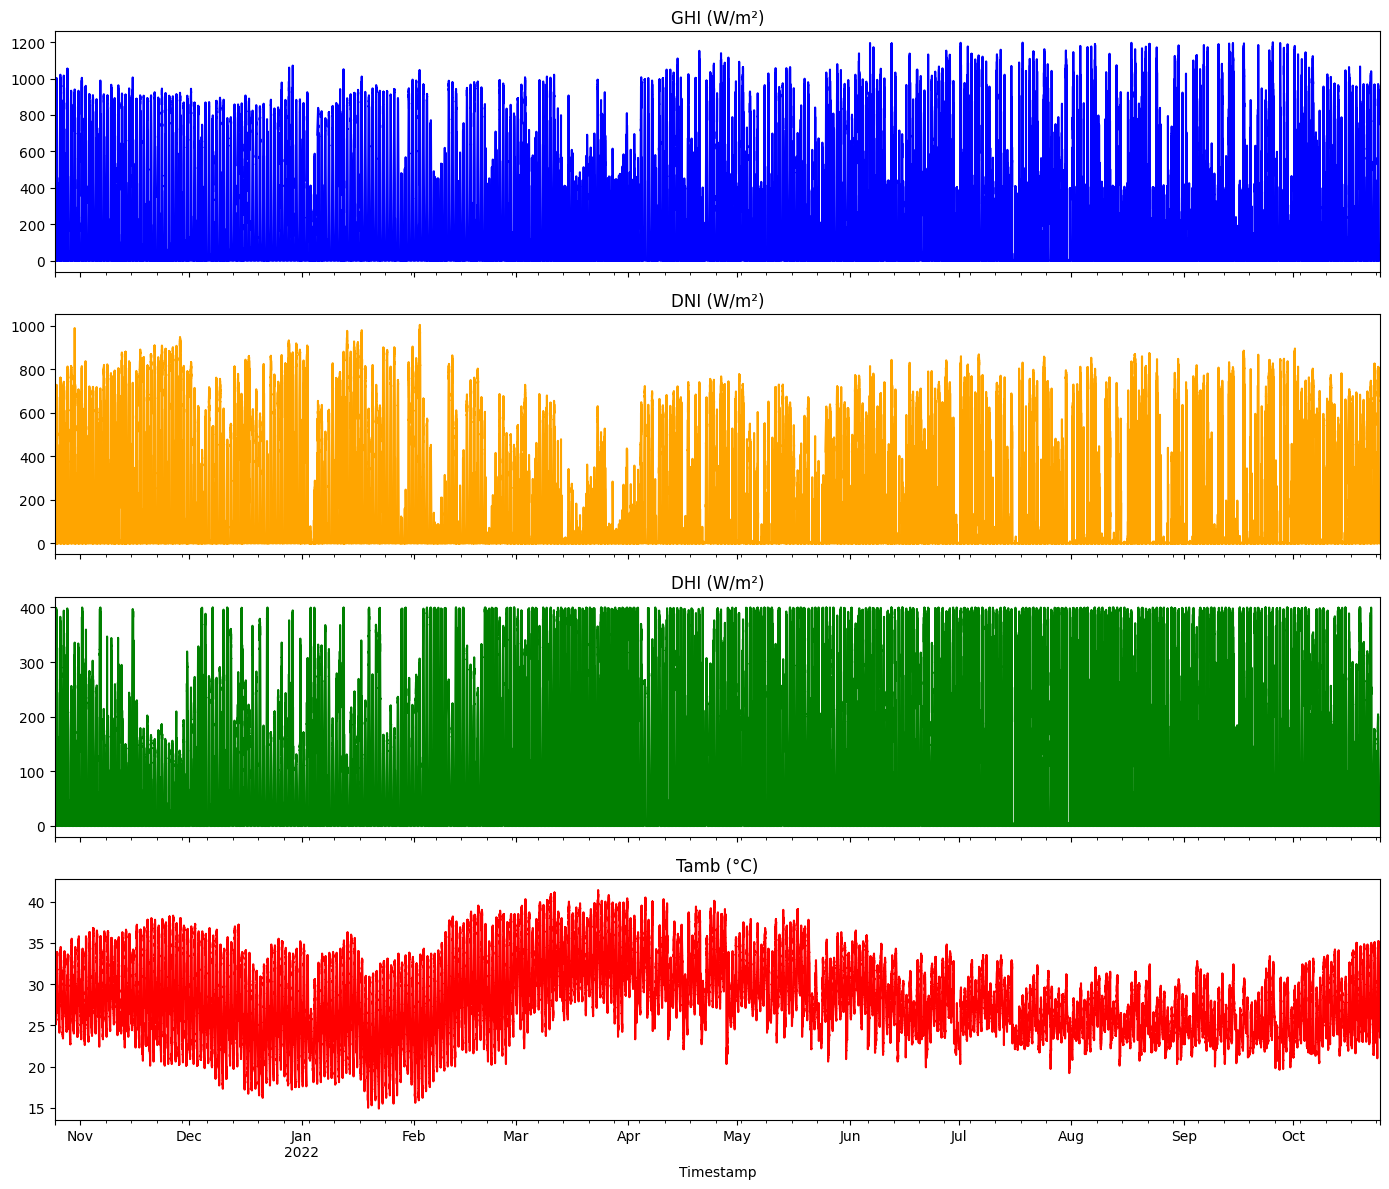

In [92]:
# Convert Timestamp to datetime and set as index

df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

# Plot GHI, DNI, DHI, Tamb in subplots
fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# Solar Irradiance
df['GHI'].plot(ax=axes[0], color='blue', title='GHI (W/m²)')
df['DNI'].plot(ax=axes[1], color='orange', title='DNI (W/m²)')
df['DHI'].plot(ax=axes[2], color='green', title='DHI (W/m²)')

# Ambient Temperature
df['Tamb'].plot(ax=axes[3], color='red', title='Tamb (°C)')

plt.tight_layout()
plt.show()

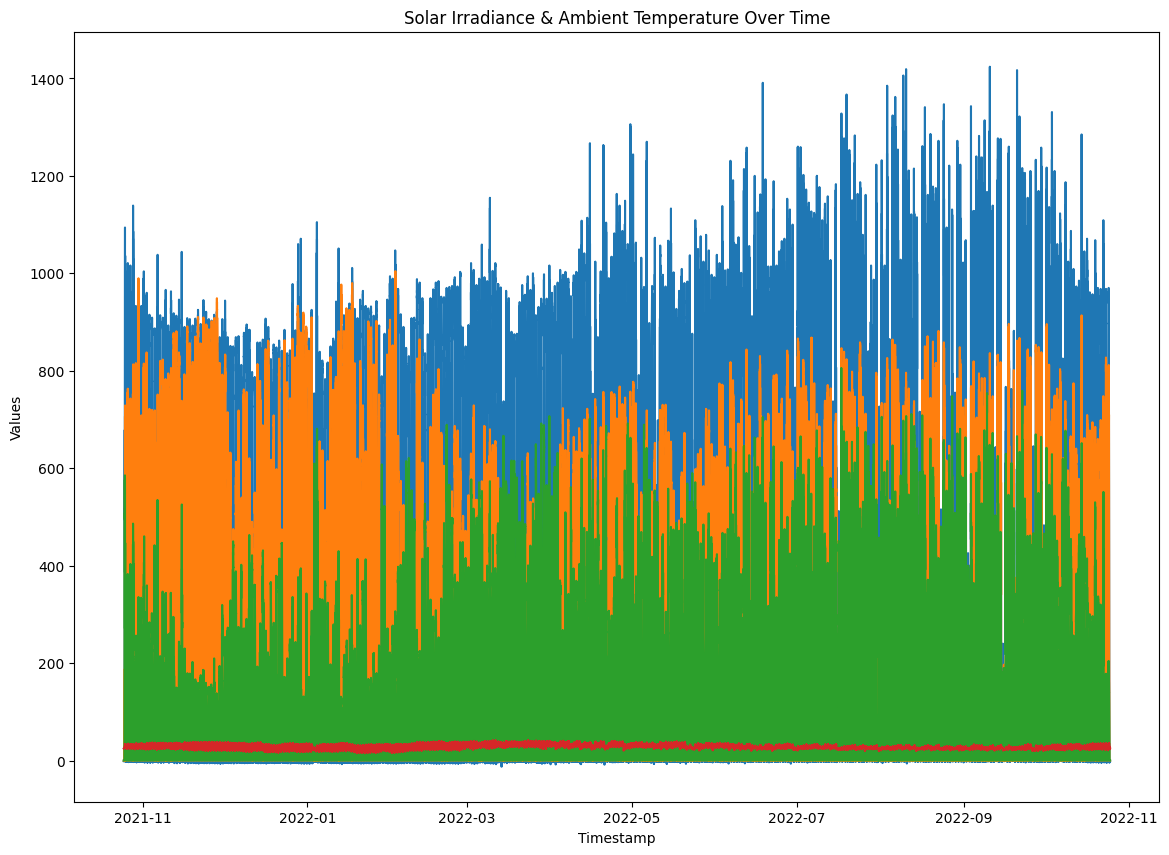

In [93]:
df = pd.read_csv('..\\data\\togo-dapaong_qc.csv', parse_dates=['Timestamp'])  # add parse_dates parameter
# Convert 'Timestamp' to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Optionally set as index for easier plotting
df.set_index('Timestamp', inplace=True)

plt.figure(figsize=(14, 10))

# Plot each variable
plt.plot(df.index, df['GHI'], label='GHI')
plt.plot(df.index, df['DNI'], label='DNI')
plt.plot(df.index, df['DHI'], label='DHI')
plt.plot(df.index, df['Tamb'], label='Tamb')

plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.title('Solar Irradiance & Ambient Temperature Over Time')
#plt.legend()
plt.show()



C:\Users\Mulat Yazew\AppData\Local\Temp\ipykernel_12208\3478173750.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = df.resample('M').mean()


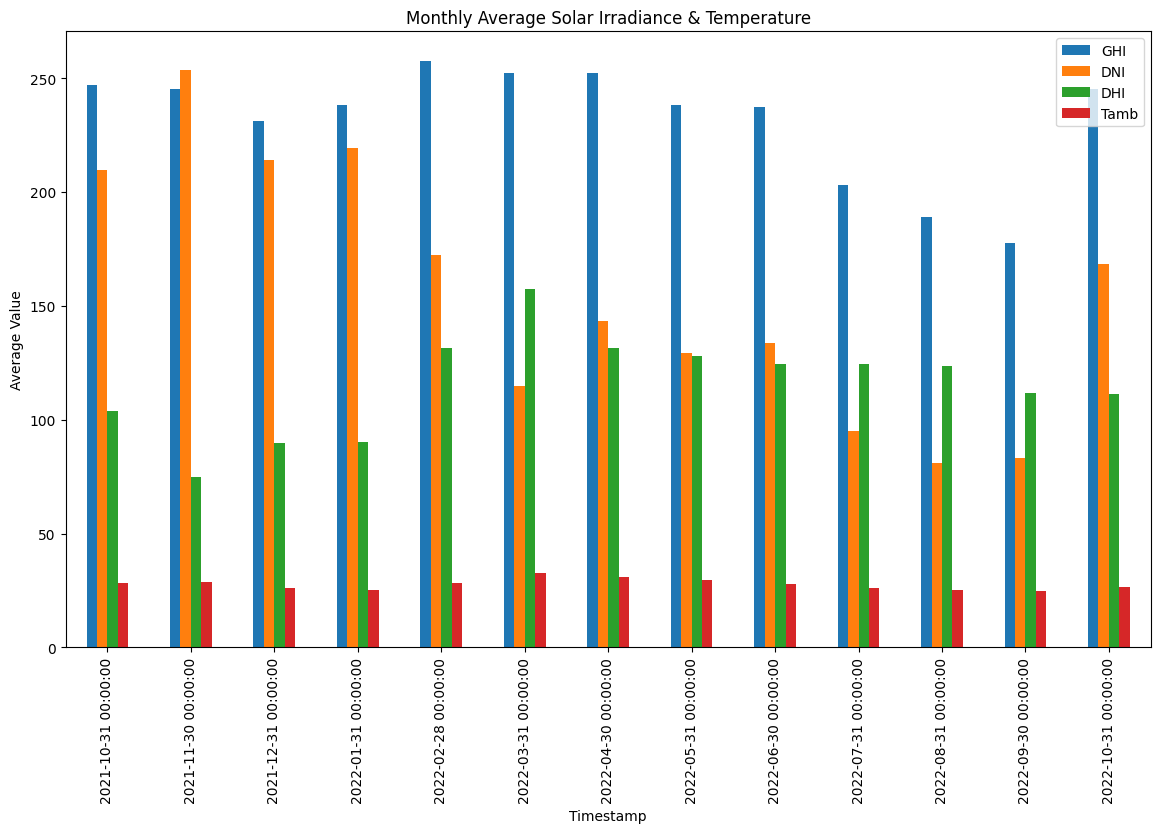

In [94]:
# Monthly average values
monthly_avg = df.resample('M').mean()

monthly_avg[['GHI', 'DNI', 'DHI', 'Tamb']].plot(kind='bar', figsize=(14, 8))
plt.title('Monthly Average Solar Irradiance & Temperature')
plt.ylabel('Average Value')
plt.show()


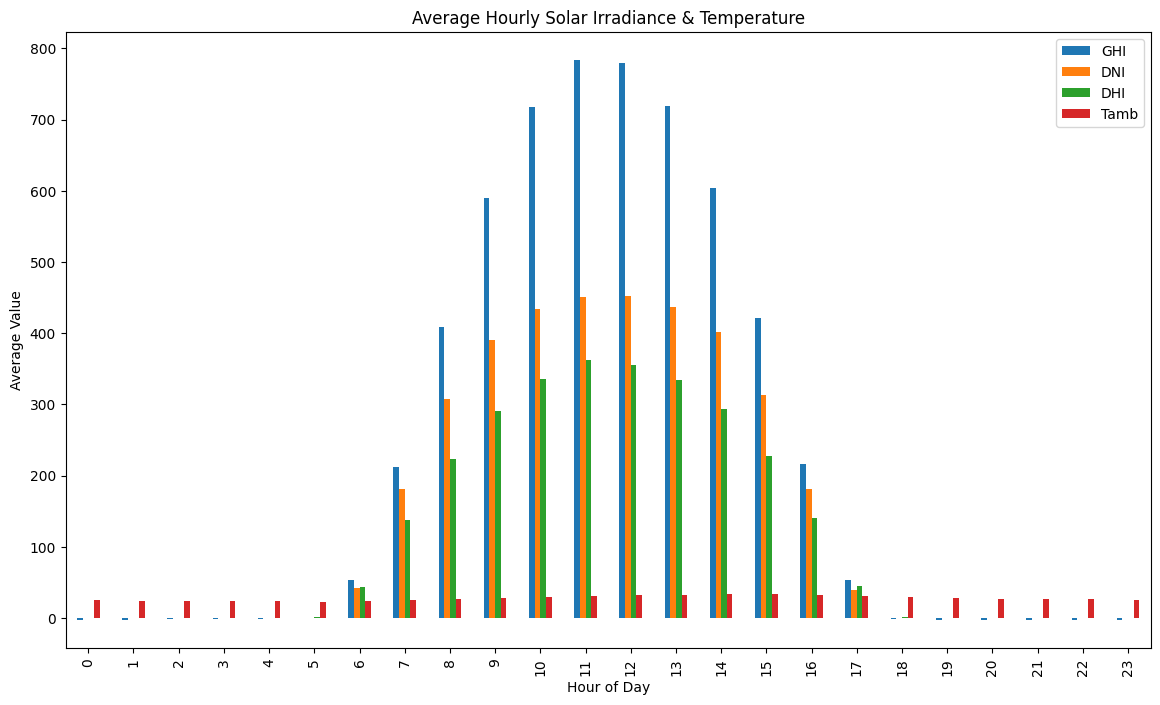

In [95]:
# Hourly average (aggregated across all days)
hourly_avg = df.groupby(df.index.hour).mean()

hourly_avg[['GHI', 'DNI', 'DHI', 'Tamb']].plot(kind='bar', figsize=(14, 8))
plt.title('Average Hourly Solar Irradiance & Temperature')
plt.xlabel('Hour of Day')
plt.ylabel('Average Value')
plt.show()


12. Cleaning Impacts

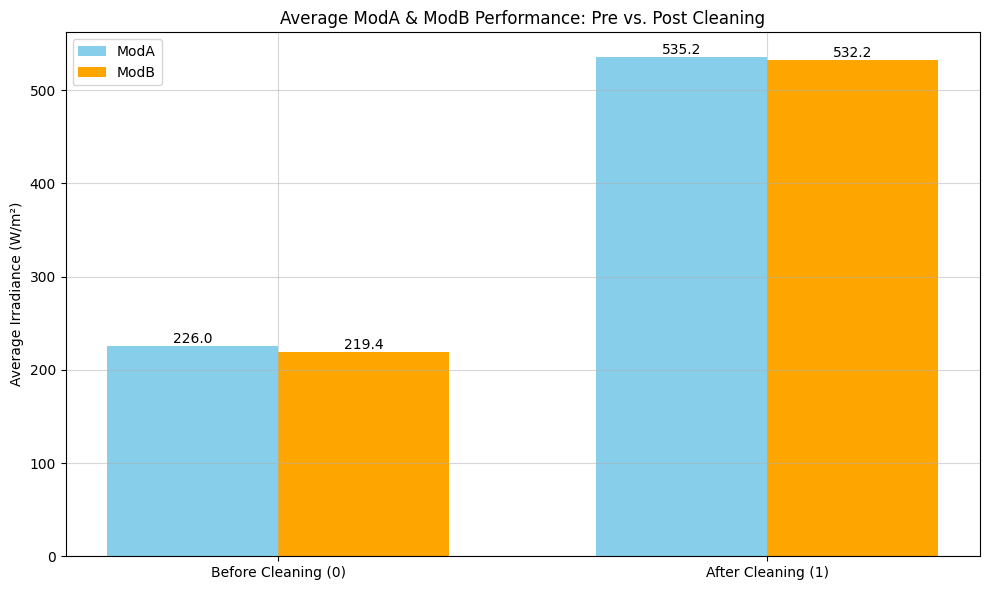

Total cleaning done:
 GHI              161674.0
DNI              102803.3
DHI               82504.8
ModA             150387.4
ModB             149551.5
Tamb               8919.2
RH                12977.8
WS                  814.2
WSgust             1123.4
WSstdev             192.3
WD                49974.5
WDstdev            4068.6
BP               274092.0
Cleaning            281.0
Precipitation         0.9
TModA             12478.8
TModB             13419.6
Comments              0.0
dtype: float64


In [96]:

# 1. Group by Cleaning flag and calculate means
cleaning_groups = df.groupby('Cleaning')[['ModA', 'ModB']].mean()

# 2. Plot the results
plt.figure(figsize=(10, 6))

# Bar positions
x = [0, 1]  # 0=Before cleaning (0), 1=After cleaning (1)
width = 0.35

# Plot ModA and ModB bars side by side
bars_moda = plt.bar([pos - width/2 for pos in x], 
                   cleaning_groups['ModA'], 
                   width, label='ModA', color='skyblue')
bars_modb = plt.bar([pos + width/2 for pos in x], 
                   cleaning_groups['ModB'], 
                   width, label='ModB', color='orange')

# Customize plot
plt.xticks(x, ['Before Cleaning (0)', 'After Cleaning (1)'])
plt.ylabel('Average Irradiance (W/m²)')
plt.title('Average ModA & ModB Performance: Pre vs. Post Cleaning')
plt.legend()

# Add value labels on top of bars
for bars in [bars_moda, bars_modb]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom')

plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()
# 3. Calculate total cleaning done
cleaning = df[df['Cleaning'] == 1].sum()
print(f"Total cleaning done:\n {cleaning}")

13. Correlation & Relationship Analysis 

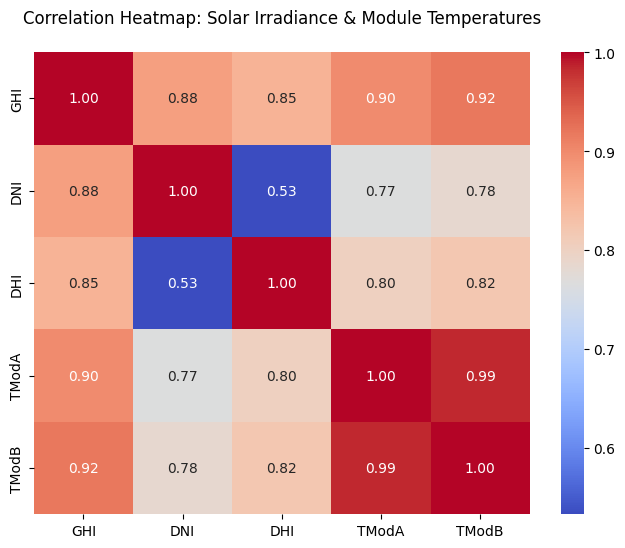

In [97]:
# Select columns of interest
corr_columns = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']
corr_matrix = df[corr_columns].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap: Solar Irradiance & Module Temperatures\n')
plt.show()


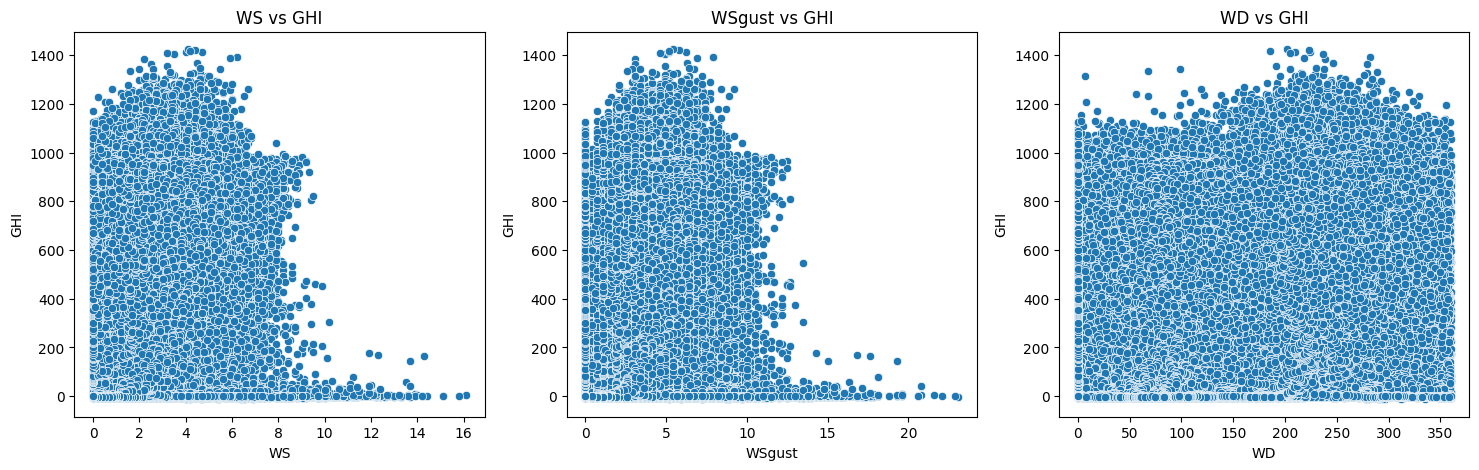

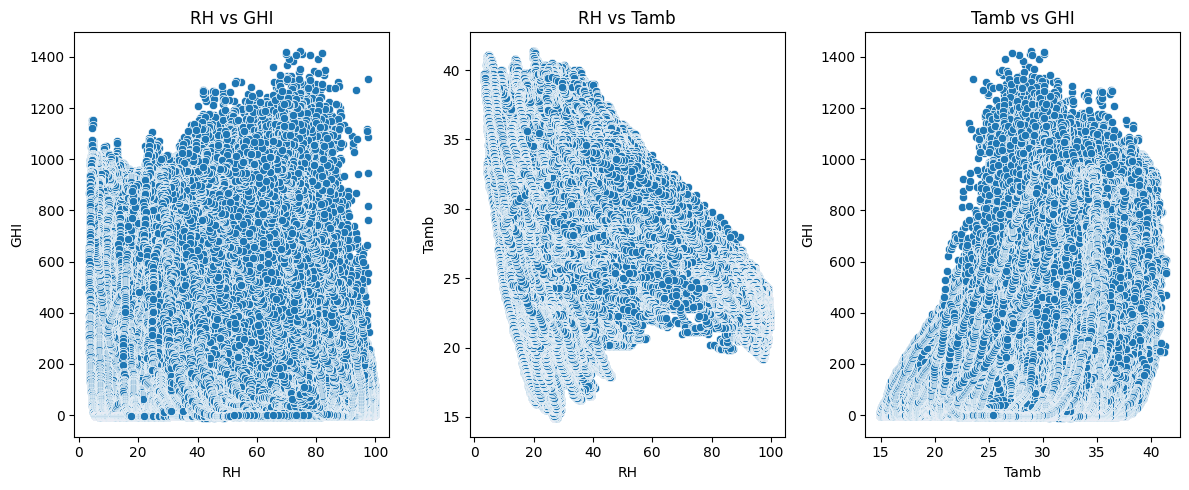

In [98]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(data=df, x='WS', y='GHI', ax=axs[0])
axs[0].set_title('WS vs GHI')

sns.scatterplot(data=df, x='WSgust', y='GHI', ax=axs[1])
axs[1].set_title('WSgust vs GHI')

sns.scatterplot(data=df, x='WD', y='GHI', ax=axs[2])
axs[2].set_title('WD vs GHI')



fig, axs = plt.subplots(1, 3, figsize=(12, 5))

sns.scatterplot(data=df, x='RH', y='GHI', ax=axs[0])
axs[0].set_title('RH vs GHI')

sns.scatterplot(data=df, x='RH', y='Tamb', ax=axs[1])
axs[1].set_title('RH vs Tamb')

sns.scatterplot(data=df, x='Tamb', y='GHI', ax=axs[2])
axs[2].set_title('Tamb vs GHI')


plt.tight_layout()
plt.show()



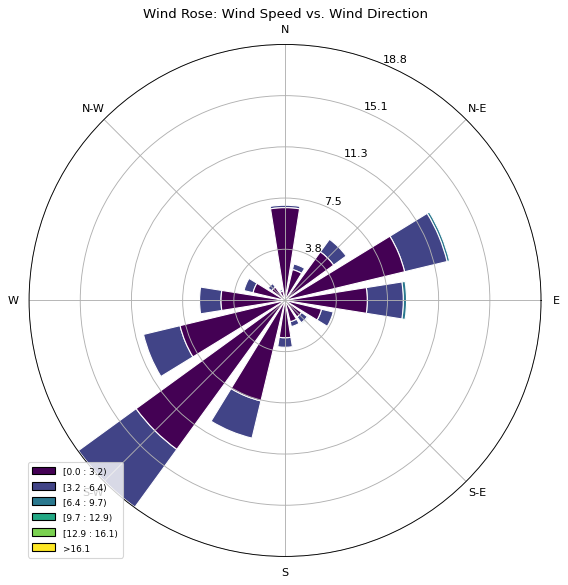

In [99]:
# Create windrose plot
ax = WindroseAxes.from_ax()
ax.bar(df['WD'], df['WS'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.title('Wind Rose: Wind Speed vs. Wind Direction')
plt.show()


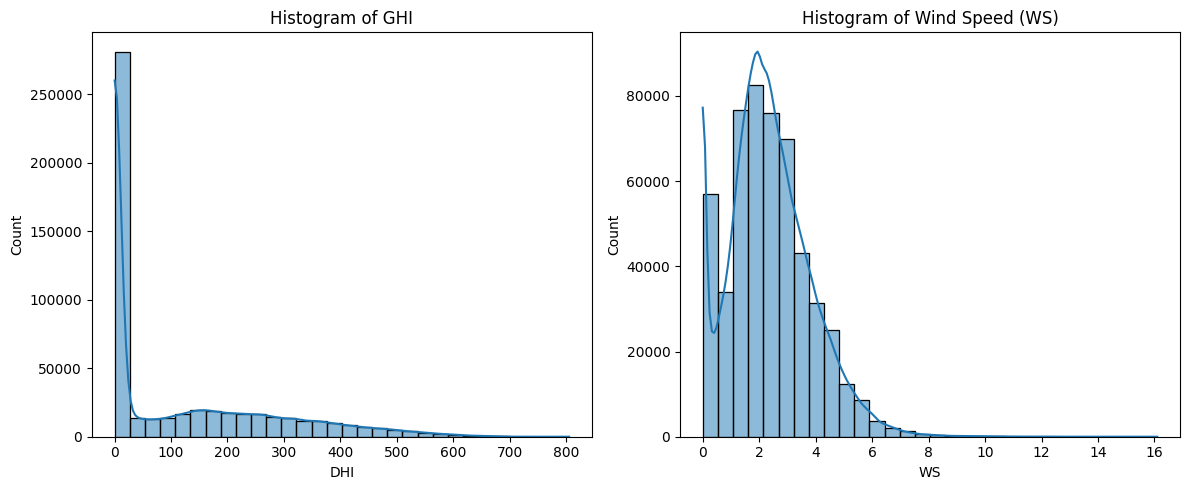

In [100]:
# Plot histograms
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df['DHI'], bins=30, kde=True, ax=axs[0])
axs[0].set_title('Histogram of GHI')

sns.histplot(df['WS'], bins=30, kde=True, ax=axs[1])
axs[1].set_title('Histogram of Wind Speed (WS)')

plt.tight_layout()
plt.show()

14. Bubble Chart

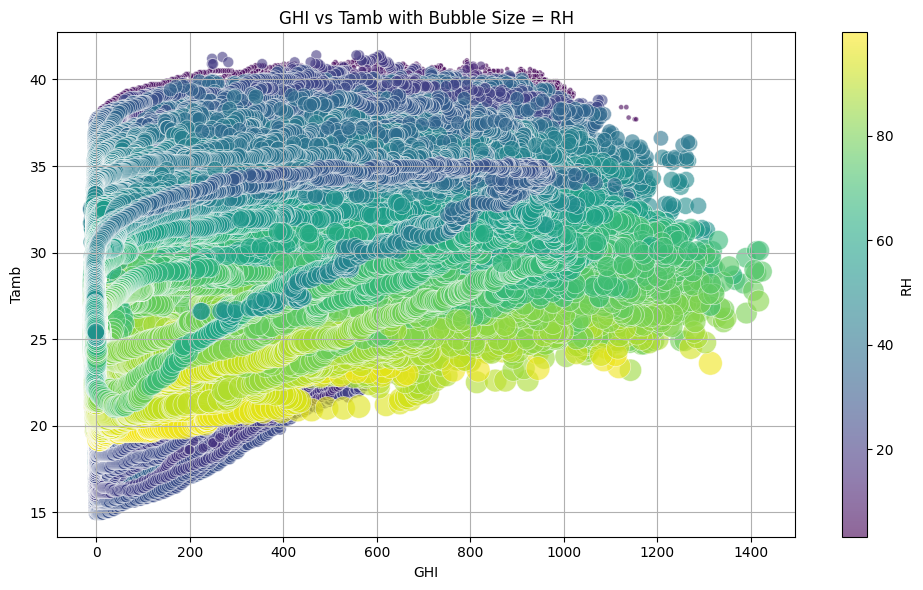

In [101]:
# Choose bubble size column: 'RH' or 'BP'
bubble_size_col = 'RH'  # Change to 'BP' if you prefer

# Normalize bubble sizes for better visualization
size = df[bubble_size_col] / df[bubble_size_col].max() * 300  # adjust multiplier as needed

# Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['GHI'], df['Tamb'], s=size, c=df[bubble_size_col], cmap='viridis', alpha=0.6, edgecolors='w', linewidth=0.5)
plt.colorbar(scatter, label=bubble_size_col)
plt.xlabel('GHI')
plt.ylabel('Tamb')
plt.title(f'GHI vs Tamb with Bubble Size = {bubble_size_col}')
plt.grid(True)
plt.tight_layout()
plt.show()
